In [1]:
import torch
import clip
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


100%|███████████████████████████████████████| 278M/278M [00:40<00:00, 7.22MiB/s]


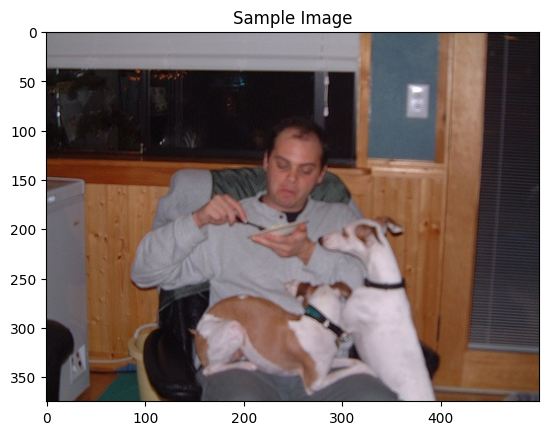

In [2]:
model, preprocess = clip.load("RN101", device=device)

sample_text = clip.tokenize(["a photo of a cat", "a photo of a dog", "a photo of a person"]).to(device)
sample_image_path = "../datasets/VOCdevkit/VOC2007/JPEGImages/001014.jpg"
sample_image = preprocess(Image.open("../datasets/VOCdevkit/VOC2007/JPEGImages/001014.jpg").convert("RGB")).unsqueeze(0).to(device)

plt.title("Sample Image")
plt.imshow(np.array(Image.open(sample_image_path)))

In [3]:
def test_text_encoder(texts):
    print("\n=== 텍스트 인코더 테스트 ===")
    
    # 토큰화
    text_tokens = clip.tokenize(texts).to(device)
    print(f"Tokenized shape: {text_tokens.shape}")
    
    # 간소화된 텍스트 인코딩 방식
    with torch.no_grad():
        # 공식 인코딩 함수 호출
        text_features = model.encode_text(text_tokens)
        
        # 정규화
        normalized_text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        print(f"Text features shape: {text_features.shape}")
        
        # 샘플 출력
        print(f"\n텍스트 피처 샘플 (첫 5개 차원):")
        for i, text in enumerate(texts):
            print(f"'{text}': {normalized_text_features[i, :5].cpu().numpy()}")
        
        return normalized_text_features
test_text_encoder(["cat", "dog", "person"])
print()


=== 텍스트 인코더 테스트 ===
Tokenized shape: torch.Size([3, 77])
Text features shape: torch.Size([3, 512])

텍스트 피처 샘플 (첫 5개 차원):
'cat': [0.01124  0.006943 0.02107  0.009605 0.00576 ]
'dog': [-0.001517 -0.002934 -0.01499   0.00809   0.009995]
'person': [ 0.01967  -0.007744  0.02498   0.003561  0.00821 ]



In [4]:
def test_image_encoder(image_paths=None):
    print("\n=== 이미지 인코더 테스트 (ResNet) ===")
    
    # 이미지가 없으면 랜덤 이미지 생성
    if not image_paths:
        # 224x224 랜덤 이미지 생성
        random_img = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
        images = [random_img]
        print("랜덤 이미지 생성됨")
    else:
        # 이미지 로드
        images = [Image.open(path).convert("RGB") for path in image_paths]
        print(f"{len(images)}개 이미지 로드됨")
    
    # 이미지 전처리
    image_inputs = [preprocess(img) for img in images]
    image_inputs = torch.stack(image_inputs).to(device)
    print(f"Preprocessed image shape: {image_inputs.shape}")
    
    # 이미지 인코딩
    with torch.no_grad():
        image_features = model.encode_image(image_inputs)
        
        # 정규화
        normalized_image_features = image_features / image_features.norm(dim=1, keepdim=True)
        
        print(f"Image features shape: {image_features.shape}")
        print(f"Image features 샘플 (첫 번째 이미지, 첫 5개 차원):")
        print(normalized_image_features[0, :5].cpu().numpy())
        
        return normalized_image_features
test_image_encoder([sample_image_path])
print()


=== 이미지 인코더 테스트 (ResNet) ===
1개 이미지 로드됨
Preprocessed image shape: torch.Size([1, 3, 224, 224])
Image features shape: torch.Size([1, 512])
Image features 샘플 (첫 번째 이미지, 첫 5개 차원):
[ 0.001513  0.00232  -0.03784   0.01971   0.001118]



In [5]:
def compute_similarity(text_features, image_features, texts):
    print("\n=== 텍스트-이미지 유사도 ===")
    
    # 코사인 유사도 계산
    similarity = 100 * (image_features @ text_features.T)
    
    for i in range(image_features.shape[0]):
        print(f"이미지 {i}:")
        for j, text in enumerate(texts):
            print(f"  '{text}': {similarity[i, j].item():.2f}")
    
    return similarity

In [6]:
def generate_similarity_map(image_path, text_prompts, patch_size=64, stride=32):
    print("\n=== 이미지-텍스트 유사도 히트맵 생성 ===")
    image = Image.open(image_path).convert("RGB")
    w, h = image.size
    
    text_features = test_text_encoder(text_prompts)
    
    heatmaps = []
    for text_idx, text_feature in enumerate(text_features):
        sim_map = np.zeros(((h - patch_size) // stride + 1, (w - patch_size) // stride + 1))
        
        for i, y in enumerate(range(0, h - patch_size + 1, stride)):
            for j, x in enumerate(range(0, w - patch_size + 1, stride)):
                patch = image.crop((x, y, x + patch_size, y + patch_size))
                patch_tensor = preprocess(patch).unsqueeze(0).to(device)

                with torch.no_grad():
                    image_feat = model.encode_image(patch_tensor)
                    image_feat /= image_feat.norm(dim=-1, keepdim=True)
                
                sim = (image_feat @ text_feature.unsqueeze(0).T).item()
                sim_map[i, j] = sim

        heatmaps.append(sim_map)

    return heatmaps, image

def plot_similarity_heatmap(image, heatmaps, text_prompts, patch_size=64, stride=32):
    for idx, heatmap in enumerate(heatmaps):
        # Resize heatmap to image size for overlay
        heatmap_resized = Image.fromarray(heatmap).resize(image.size, resample=Image.BILINEAR)
        heatmap_np = np.array(heatmap_resized)
        
        # Normalize
        heatmap_np = (heatmap_np - np.min(heatmap_np)) / (np.max(heatmap_np) - np.min(heatmap_np) + 1e-6)

        # Show
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.imshow(heatmap_np, cmap='jet', alpha=0.5)
        plt.title(f"Similarity to: '{text_prompts[idx]}'")
        plt.axis('off')
        plt.colorbar(label='Similarity')
        plt.show()


=== 이미지-텍스트 유사도 히트맵 생성 ===

=== 텍스트 인코더 테스트 ===
Tokenized shape: torch.Size([3, 77])
Text features shape: torch.Size([3, 512])

텍스트 피처 샘플 (첫 5개 차원):
'cat': [0.01124  0.006943 0.02107  0.009605 0.00576 ]
'dog': [-0.001517 -0.002934 -0.01499   0.00809   0.009995]
'person': [ 0.01967  -0.007744  0.02498   0.003561  0.00821 ]


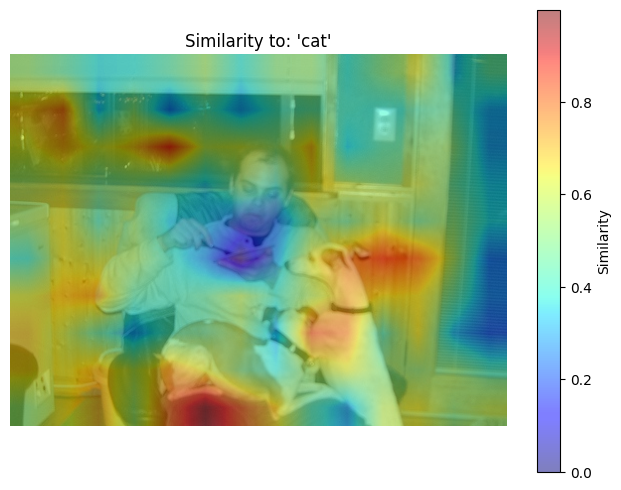

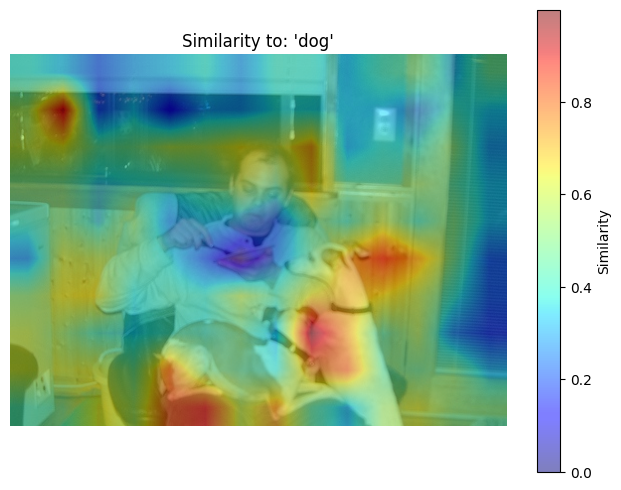

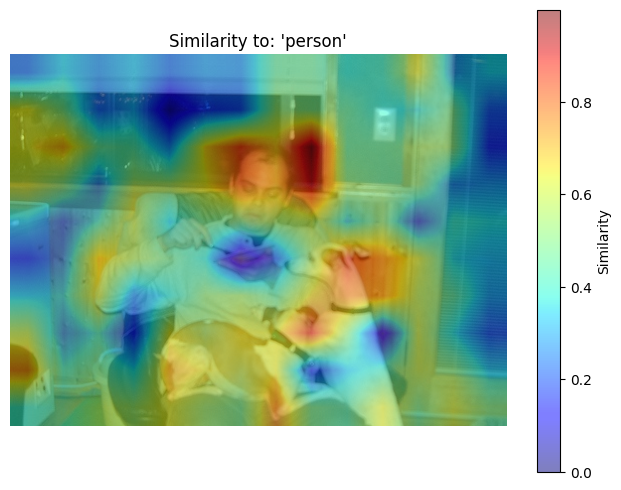

In [7]:
text_prompts = ["cat", "dog", "person"]
heatmaps, img = generate_similarity_map(sample_image_path, text_prompts)
plot_similarity_heatmap(img, heatmaps, text_prompts)